In [1]:
%pip install deap

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Ven\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


### Задача
Задача состоит в том, чтобы при помощи генетического алгоритма реализовать выделение признаков для классификации набора данных. Реализуемый в ходе выполнения данной работы класс выполняет обучение классификации на основе выделенных признаков, перечисляющихся ему извне. Генетический алгоритм совершает подбор признаков, необходимых для более успешной работы классификатора

### Подключение библиотек

In [2]:
import deap
from deap import tools
from deap import algorithms
from deap import base
from deap import creator

import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

### Определение констант

In [3]:
POPULATION_SIZE = 50
P_CROSSOVER = 0.9 # вероятность скрещивания
P_MUTATION = 0.3 # вероятность мутации
MAX_GENERATIONS = 50
HALL_OF_FAME_SIZE = 5
FEATURE_PENALTY_FACTOR = 0.001
# установление сида для генератора случайных чисел
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

### Модификация функции eaSimple

In [4]:
def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm is similar to DEAP eaSimple() algorithm, with the modification that
    halloffame is used to implement an elitism mechanism. The individuals contained in the
    halloffame are directly injected into the next generation and are not subject to the
    genetic operators of selection, crossover and mutation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # add the best back to population:
        offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

### Описание класса классификатора
Вместо того чтобы разбивать данные на обучающий и тестовый наборы,
в данном случае воспользовались k-групповым перекрестным
контролем.

Метод getMeanAccuracy() вычисляет качество классификатора для
множества отобранных признаков. Для оценки классификатора применяется метрика, называемая верностью, – доля правильно классифицированных примеров. Например, верность 0.85 означает, что 85% всех примеров были классифицированы правильно. Поскольку мы обучаем и оцениваем классификатор k раз, то используем верность, усредненную по этим k вычислениям.

In [5]:
class Medic:
    NUM_FOLDS = 3

    def __init__(self, randomSeed):
        self.randomSeed = randomSeed
        self.data = pd.read_csv('breast-cancer-wisconsin1.data', header=None, usecols=range(1,11))
        self.X = self.data.iloc[:, 0:9]
        self.y = self.data.iloc[:, 9]
        # k-групповой перекрёстный контроль для формирования обучающих и тестовых выборок
        self.kfold = model_selection.KFold(n_splits=self.NUM_FOLDS,
                                            random_state=self.randomSeed,
                                            shuffle=True)
        # Классификатор дерево решений
        self.classifier = DecisionTreeClassifier(random_state=self.randomSeed)

    def __len__(self):
        return self.X.shape[1]

    def getMeanAccuracy(self, zeroOneList):
        zeroIndices = [i for i, n in enumerate(zeroOneList) if n == 0]
        currentX = self.X.drop(self.X.columns[zeroIndices], axis=1)
        cv_results = model_selection.cross_val_score(self.classifier,
                                                    currentX, self.y,
                                                    cv=self.kfold,
                                                    scoring='accuracy')
        return cv_results.mean()

### Функция test
Cоздает экземпляр класса Medic и оценивает классификатор, обученный на всех 9 признаках, присутствующих в представлении, содержащем все единицы

Результат выполнения метода test показывает, что при обучении
классификатора методом 3-группового перекрестного контроля на всех
9 признаках достигается верность 94%

Далее мы попробуем улучшить верность классификатора, выделив
только часть признаков

In [6]:
def test():
    medic = Medic(randomSeed=RANDOM_SEED)

    allOnes = [1] * len(medic)
    print("-- Выделены все признаки:", allOnes, ", верность =", medic.getMeanAccuracy(allOnes))

test()

-- Выделены все признаки: [1, 1, 1, 1, 1, 1, 1, 1, 1] , верность = 0.9427753934191703


### Решение с помощью генетического алгоритма
Поскольку мы стремимся максимизировать верность модели
классификации, определим единственную цель – максимизирующую
стратегию приспособления

In [7]:
medic = Medic(RANDOM_SEED)
toolbox = base.Toolbox()

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
# Создание начальной популяции индивидуумов
toolbox.register("zeroOrOne", random.randint, 0, 1)
toolbox.register("individualCreator", tools.initRepeat, creator.Individual,
                toolbox.zeroOrOne, len(medic))
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)


### Функция расчёта приспособленности
Здесь вызывается метод getMeanAccuracy() объекта класса Medic для вычисления приспособленности индивидуума с некоторыми изменениями:
1. мы запретили алгоритму не выбирать ни одного признака (создавать
индивидуума, представленного только нулями), поскольку в таком
случае классификатор возбудил бы исключение;
2. мы добавили небольшой штраф за каждый отобранный признак,
чтобы побудить алгоритм выделять меньше признаков. Штраф
совсем невелик (0.001), поэтому будет использоваться, только чтобы
разрешить неоднозначность в случае, когда качество двух
классификаторов одинаково – тогда предпочтение будет отдано
тому, который обошелся меньшим числом признаков.

In [8]:
def medicClassificationAccuracy(individual):
    numFeaturesUsed = sum(individual)
    if numFeaturesUsed == 0:
        return 0.0,
    else:
        accuracy = medic.getMeanAccuracy(individual)
        return accuracy - FEATURE_PENALTY_FACTOR * numFeaturesUsed,

toolbox.register("evaluate", medicClassificationAccuracy)

### Основной алгоритм: отбор, скрещивание и мутации

In [9]:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/len(medic))

### Финальная функция main()

gen	nevals	max     	avg     
0  	50    	0.940637	0.906309
1  	41    	0.954082	0.930244
2  	40    	0.954082	0.936376
3  	43    	0.955082	0.93944 
4  	42    	0.955082	0.940378
5  	38    	0.955082	0.942275
6  	43    	0.955082	0.9441  
7  	41    	0.955082	0.946334
8  	44    	0.955082	0.946729
9  	44    	0.955082	0.945332
10 	42    	0.955082	0.94809 
11 	42    	0.955082	0.949758
12 	41    	0.955082	0.95001 
13 	39    	0.955082	0.949237
14 	44    	0.955082	0.948602
15 	44    	0.955082	0.948708
16 	43    	0.955082	0.95055 
17 	41    	0.955082	0.950885
18 	42    	0.955082	0.932839
19 	44    	0.955082	0.948962
20 	44    	0.955082	0.951039
21 	38    	0.955082	0.949692
22 	43    	0.955082	0.94829 
23 	45    	0.955082	0.947981
24 	41    	0.955082	0.945675
25 	39    	0.955082	0.949995
26 	44    	0.955082	0.948974
27 	43    	0.955082	0.949394
28 	41    	0.955082	0.949983
29 	42    	0.955082	0.946759
30 	45    	0.955082	0.946902
31 	41    	0.955082	0.948768
32 	39    	0.955082	0.948574
33 	41    	0.9

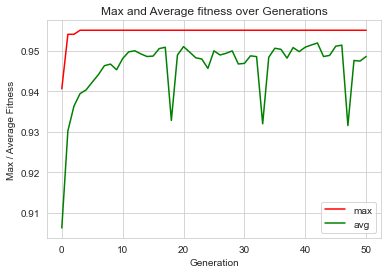

In [10]:
def main():
    # создание начальной популяции
    population = toolbox.populationCreator(n=POPULATION_SIZE)
    # Определение статистик
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)
    # Определение зала славы
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
    # Выполнение основного алгоритма
    population, logbook = eaSimpleWithElitism(population, toolbox,
            cxpb=P_CROSSOVER, mutpb=P_MUTATION, ngen=MAX_GENERATIONS,
            stats=stats, halloffame=hof, verbose=True)

    # Вывод лучших решений
    print("- Лучшие решения:")
    for i in range(HALL_OF_FAME_SIZE):
        print(i, ":", hof.items[i], ", приспособленность =", hof.items[i].fitness.values[0],
                ", верность =", medic.getMeanAccuracy(hof.items[i]),
                ", признаков =", sum(hof.items[i]))

    # извлечение статистик
    maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")
    # отображение статистик на графики
    sns.set_style("whitegrid")
    labels = ['max', 'avg']
    plt.plot(maxFitnessValues, color='red', label=labels[0])
    plt.plot(meanFitnessValues, color='green', label=labels[1])
    plt.xlabel('Generation')
    plt.ylabel('Max / Average Fitness')
    plt.title('Max and Average fitness over Generations')
    plt.legend(labels)
    plt.show()

if __name__=="__main__":
    main()